In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [35]:
results_1 = pickle.load(gzip.open('results/trace_L1_notorque_results.gz', 'rb'))
results_2 = pickle.load(gzip.open('results/trace_L1_noforce_results.gz', 'rb'))
results_3 = pickle.load(gzip.open('results/trace_L1_noforce_notorque_results.gz', 'rb'))
results = [results_1, results_2,results_3]
labels = ["Free torque", "Free force", "Both free"]

comparison_results = pickle.load(gzip.open('results/trace_L1_results.gz','rb'))

In [36]:
x_1 = results[0][-1][0]
y_1 = results[0][-1][1]
for rel in results: del(rel[-1])
x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

best = []
for j in range(3):
    data_error = [extractn(res,2) for res in results[j]]

    reg_error = [extractn(res,3) for res in results[j]]
    lvals = [extractn(res,4) for res in results[j]]

    # kill all nones

    data_error = [item for item in data_error if item is not None]
    reg_error = [item for item in reg_error if item is not None]
    lvals = [item for item in lvals if item is not None]

    l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
                (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
    best += [np.argsort(l_curve_distances)[-1]]
    
# extract the comparison forces

de = [extractn(res,2) for res in comparison_results[:-1]]
re = [extractn(res,3) for res in comparison_results[:-1]]
l_dist = np.abs((re[-1]-re[0])*np.array(de) -  \
                (de[-1]-de[0])*np.array(re)+de[-1]*re[0]-re[-1]*de[0])

best_comp = np.argsort(l_dist)[-1]

Fx_comp = comparison_results[best_comp][0][:,0].reshape((len(x_1),len(y_1))).transpose()
Fy_comp = comparison_results[best_comp][0][:,1].reshape((len(x_1),len(y_1))).transpose()

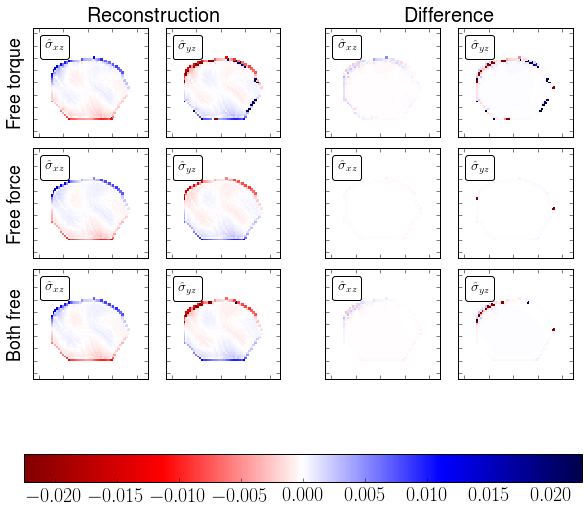

In [42]:
fig = plt.figure(figsize=(10,9))
#fig = plt.figure()
maxmagnitude = 0.03
gs0 = gridspec.GridSpec(3,1, hspace = 0.1,wspace=0.1)

gs_j = []
gs_j_innergrids = []
ax = []
im = []

for j in range(3):
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=gs0[j],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
    gs_j_innergrids+= [[]]
    
    Fx = results[j][best[j]][0][:,0].reshape((len(x_1),len(y_1))).transpose()
    Fy = results[j][best[j]][0][:,1].reshape((len(x_1),len(y_1))).transpose()
    # form a new 2x1 subplot of the results
    
    gs_j_innergrids[j] +=  [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,0], wspace=0.0, hspace = 0.0)] 
    ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    ax[-1].set_ylabel(labels[j],fontsize=18)
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])

    #plt.axis('off')
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(Fx, np.abs(Fx) < 1e-5)    
    im += [ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75)]
    
    im[-1].axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fy, np.abs(Fy) < 1e-5)        
    im += [ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75)]
    
    im[-1].axes.set_aspect('equal')
    
    # form a new 2x1 subplot of the differences
    
    gs_j_innergrids[j] +=  [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,1], wspace=0.0, hspace = 0.0)] 
    ax += [plt.Subplot(fig, gs_j_innergrids[j][1][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(Fx-Fx_comp, np.abs(Fx-Fx_comp) < 1e-5)    
    im += [ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75)]
    
    im[-1].axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][1][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fy-Fy_comp, np.abs(Fy-Fy_comp) < 1e-5)        
    im += [ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75)]
    
    im[-1].axes.set_aspect('equal')
    
ax[0].text(100,220,r"Reconstruction",fontsize=20)
ax[2].text(120,220,r"Difference",fontsize=20)
fig.colorbar(im[0], ax = ax, orientation='horizontal').ax.tick_params(labelsize=20)

    
plt.savefig("../figures/fig3.png",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.15, dpi=400)    